In [28]:
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

import joblib
from scipy.spatial import ConvexHull
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [3]:
workingdf = pd.read_csv("model_input/sim_data.csv")

In [4]:
X = workingdf.drop(columns=["Anomaly"])
Y = workingdf["Anomaly"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and evaluation sets
# Adjust the test_size parameter as needed (e.g., 0.2 for a 80-20 split)
X_train, X_test, Y_train, y_true = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42
)

In [6]:
# Initialize and train the Isolation Forest
iso_forest_model = IsolationForest(
    n_estimators=1000, max_samples=0.5, contamination=0.01, random_state=42
)

iso_forest_model.fit(X_train)

IsolationForest(contamination=0.01, max_samples=0.5, n_estimators=1000,
                random_state=42)

In [16]:
# Predict anomalies on the test set
output_df = X_test.copy()
pred = iso_forest_model.predict(X_test)
output_df = pd.DataFrame(output_df, columns=X.columns)
output_df["anomaly_pred"] = pred

# Convert 1 (anomaly) and 0 (normal) to boolean for easier interpretation
output_df["anomaly_pred"] = output_df["anomaly_pred"].replace({-1: 1, 1: 0})

# Number of anomalies in the test set
num_anomalies = output_df["anomaly_pred"].sum()

Number of anomalies detected in the test set: 202 0.0101
Accuracy: 0.996
Precision: 0.806930693069307
Recall: 0.7990196078431373
F1-score: 0.8029556650246306


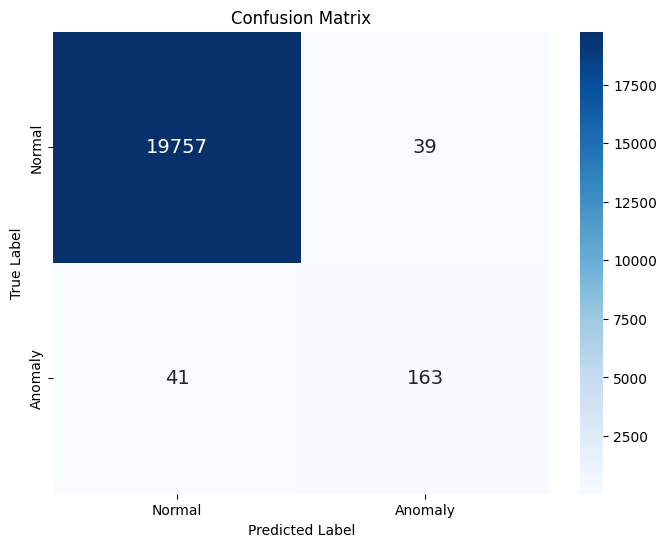

In [18]:
print(
    f"Number of anomalies detected in the test set: {num_anomalies} {num_anomalies / len(output_df)}"
)
# True labels
y_pred = output_df["anomaly_pred"]


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

conf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

print 
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    cmap="Blues",
    fmt="g",
    annot_kws={"size": 14},
    xticklabels=["Normal", "Anomaly"],
    yticklabels=["Normal", "Anomaly"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

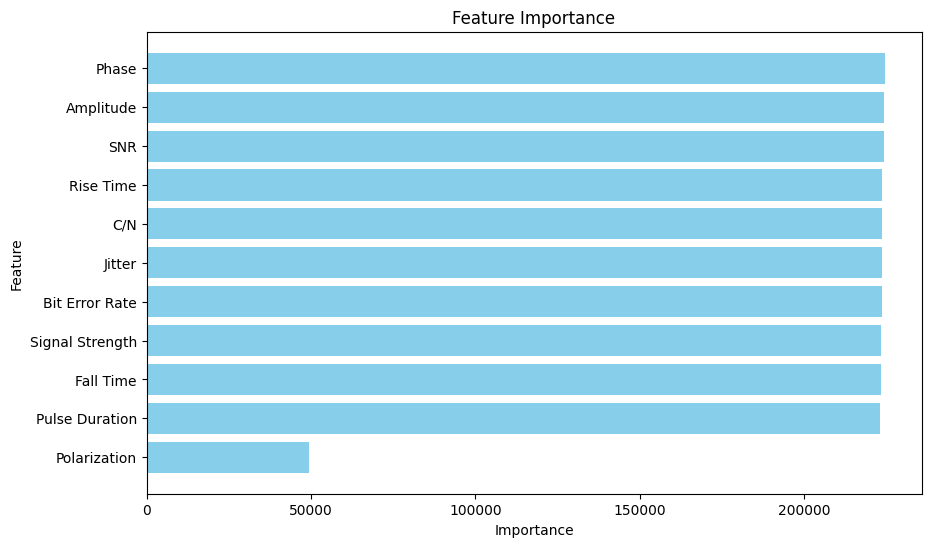

In [19]:
# Plotting feature importance
trees = iso_forest_model.estimators_

# Get feature names from the DataFrame
feature_names = output_df.columns
feature_names

# Initialize a dictionary to store feature importance
feature_importance = {}

# Iterate over each tree
for tree in trees:
    # Iterate over each split
    for feature, threshold in zip(tree.tree_.feature, tree.tree_.threshold):
        if feature != -2:  # Check if the split is not a leaf node
            if feature_names[feature] not in feature_importance:
                feature_importance[feature_names[feature]] = 1
            else:
                feature_importance[feature_names[feature]] += 1

# Sort the feature importance dictionary
sorted_feature_importance = sorted(
    feature_importance.items(), key=lambda x: x[1], reverse=True
)
# Sort the feature importance dictionary
sorted_feature_importance = sorted(
    feature_importance.items(), key=lambda x: x[1], reverse=True
)

# Extract feature names and importance scores for plotting
features = [feat for feat, _ in sorted_feature_importance]
importance = [imp for _, imp in sorted_feature_importance]

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(features, importance, color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

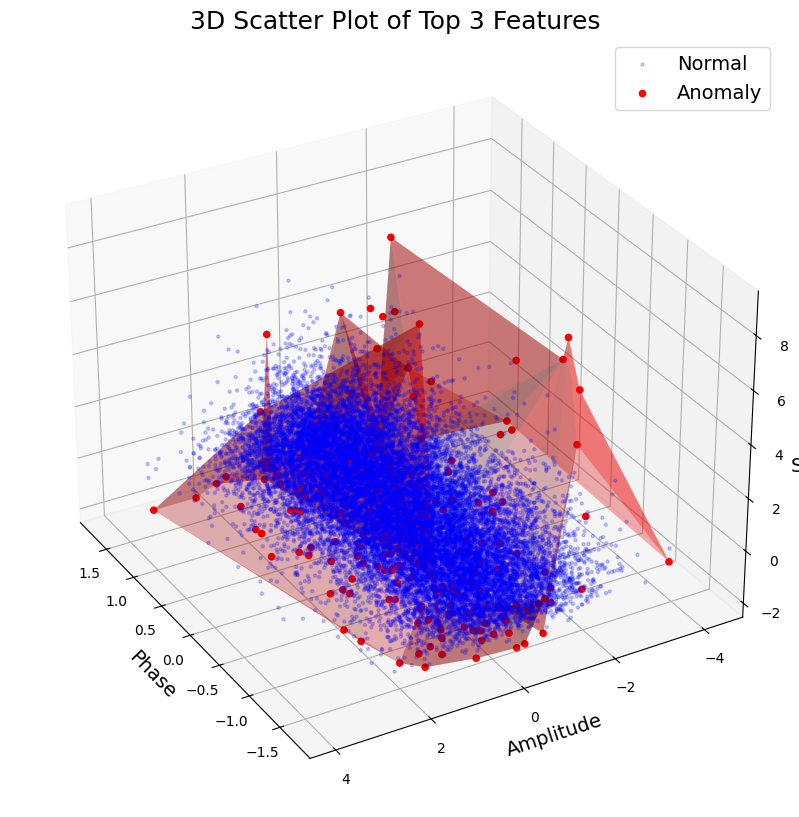

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get the top 3 most important features
top_features = [feat for feat, _ in sorted_feature_importance[:3]]

# Extract the top 3 features and the anomaly labels from the output DataFrame
X_top = output_df[top_features]
y = output_df["anomaly_pred"]

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot normal instances in blue (smaller and transparent)
normal_instances = X_top[y == 0]
ax.scatter(
    normal_instances[top_features[0]],
    normal_instances[top_features[1]],
    normal_instances[top_features[2]],
    c="b",
    label="Normal",
    s=5,
    alpha=0.2,
)

# Plot anomalies in red (larger and opaque)
anomalies = X_top[y == 1]
anomaly_scatter = ax.scatter(
    anomalies[top_features[0]],
    anomalies[top_features[1]],
    anomalies[top_features[2]],
    c="r",
    label="Anomaly",
    s=20,
    alpha=1.0,
)

# Add labels and title
ax.set_xlabel(top_features[0], fontsize=14)
ax.set_ylabel(top_features[1], fontsize=14)
ax.set_zlabel(top_features[2], fontsize=14)
ax.legend(fontsize=14)
ax.set_title("3D Scatter Plot of Top 3 Features", fontsize=18)

# Rotate the plot to make anomalies more visible
ax.view_init(30, 150)  # Adjust the elevation and azimuth angles as needed

# Add a transparent poly surface to visualize the anomaly cluster
anomaly_hull = ConvexHull(anomalies[top_features].values)
ax.plot_trisurf(
    anomalies[top_features[0]].values[anomaly_hull.vertices],
    anomalies[top_features[1]].values[anomaly_hull.vertices],
    anomalies[top_features[2]].values[anomaly_hull.vertices],
    color="r",
    alpha=0.3,
)

plt.show()

In [140]:
out = output_df.copy()
out['anomaly'] = y_true
out.head(1000).to_csv("output/output.csv", index=False)

## Model Preformance

In [156]:
# Save the model to a file
joblib.dump(iso_forest_model, "iforest_model.pkl")

['iforest_model.pkl']

In [157]:
# Load the model
model = joblib.load("iforest_model.pkl")

# Extract tree structures and decision rules
trees = model.estimators_


# Function to extract tree information
def extract_tree(tree):
    tree_ = tree.tree_
    features = tree_.feature
    thresholds = tree_.threshold
    children_left = tree_.children_left
    children_right = tree_.children_right
    return features, thresholds, children_left, children_right


# Extract all trees' information
all_trees = [extract_tree(tree) for tree in trees]

# Example output for the first tree
features, thresholds, children_left, children_right = all_trees[0]
print("Features:", features)
print("Thresholds:", thresholds)
print("Children left:", children_left)
print("Children right:", children_right)

Features: [ 4  6  3 ... -2 -2 -2]
Thresholds: [-2.37686035e-03 -6.36968759e-01  7.44885672e+00 ... -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00]
Children left: [ 1  2  3 ... -1 -1 -1]
Children right: [1766 1577  234 ...   -1   -1   -1]
